In [1]:
#!pip install emoji
#!pip install fasttext
#!pip install transformers
#!pip install transformers
#https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d

In [2]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,  Dropout, Input, LSTM, Embedding,SpatialDropout1D, BatchNormalization, Flatten, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import re

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet as wn
from nltk import word_tokenize,pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict        
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow_datasets as tfds


tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import pickle

from sklearn.metrics import confusion_matrix

from gc import callbacks
import keras_tuner as kt

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7525225896841479157
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1489371136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5097842216434565043
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/n/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/n/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/n/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/n/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2024-04-03 12:17:27.767444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04

In [3]:
# print(tf.__version__)
# import tensorflow_hub as hub

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)



Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


2024-04-03 12:17:29.837333: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 12:17:29.837466: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 12:17:29.837510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Read dataset


In [16]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


In [17]:
for i, o in train_dataset.take(1):
    print(i, o)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)


2024-04-03 12:22:41.350075: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [19]:
data_list = []
for features, label in train_dataset:
    data_list.append((features.numpy().decode('utf-8'), label.numpy()))

# Create a Pandas DataFrame
train_dataset = pd.DataFrame(data_list)
train_dataset

,0,1
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1
...,...,...
24995,"I have a severe problem with this show, severa...",0
24996,"The year is 1964. Ernesto ""Che"" Guevara, havin...",1
24997,Okay. So I just got back. Before I start my re...,0
24998,When I saw this trailer on TV I was surprised....,0


In [20]:
data_list = []
for features, label in test_dataset:
    data_list.append((features.numpy().decode('utf-8'), label.numpy()))

# Create a Pandas DataFrame
test_dataset = pd.DataFrame(data_list)
test_dataset

,0,1
0,There are films that make careers. For George ...,1
1,"A blackly comic tale of a down-trodden priest,...",1
2,"Scary Movie 1-4, Epic Movie, Date Movie, Meet ...",0
3,Poor Shirley MacLaine tries hard to lend some ...,0
4,As a former Erasmus student I enjoyed this fil...,1
...,...,...
24995,"Feeling Minnesota is not really a road movie, ...",0
24996,"This is, without doubt, one of my favourite ho...",1
24997,Most predicable movie I've ever seen...extreme...,0
24998,It's exactly what I expected from it. Relaxing...,1


# Set Parameters

In [4]:
TRAIN_MODE= True
emb_dim=50
batchsize=256

sequence_size= 500
READ_DATA = False
TRAIN_WORD_SENTIMENT = False
ETL_STOPWORDS= False
FIT_MODEL = False
FIT_ATTENTION_MODELV2 = False
FIT_TRANSFORMER_MODEL = True
ETL_SENTENCE_SIZE = False

MAKE_PREDICTION = True

TUNNING = False
TUNNING_ATTENTION_V2 = False
TUNNING_TRANSFORMER = True

max_trials = 30
threshold = 1
classN=1
tf.random.set_seed(0)
np.random.seed(0)

In [5]:

Emoji_Dict ={
    ":p" : "<>" ,
    ":)" :"<SMILE_SIMPLE>",
    ":(":"<SAD>",
    ":'(":"<CRY>",
    ":')":"<BLINK_EYE>",
    ":d" : "<BIG_SMILE>", 
    ":-)":"<SMILE_HAPPY>",
    ";-)":"<SMILE_A_LOT>",
    ":<})":"<MOUSTACHE_SMILE>",
    ":-||":"<MAD>",
    ":-(":"<SAD>", 
    ":'-(":"<CRY>",
    ":-))":"<HAPPY>",
    ":-*": "<KISS>",
    ":-P~":"<LICK>", 
    ":-o" :"<SURPRISED>",
    ":-|":"<GRIM>",
    ":-/":"<PERPLEXED>",
    "=:O"  :"<FRIGHTNED>",
    "<3": "<LOVE>",
    "*****": "<5_STARS>",
    "****": "<4_STARS>",
    "***": "<3_STARS>",
    "**": "<2_STARS>",
    "*": "<1_STARS>",
    ".org" : "<>"
    }

SPECIAL_NUMBERS = {
    "1" : "<1_STARS>",
    "2": "<2_STARS>",
    "3": "<3_STARS>",
    "4": "<4_STARS>", 
    "5": "<5_STARS>"
}

# Set Functions to perform data cleaning and feature engineering

In [6]:

def translate_sentiment(sentiment, op=4):
    if op ==4:
        if sentiment >0 and sentiment <=3 :
            sentiment = 0
        elif sentiment >3 and sentiment < 5 :
            sentiment = 1
        elif sentiment >=5 and sentiment <=8 :
            sentiment = 2
        elif sentiment >8 and sentiment <=10 :
            sentiment = 3
    else:
        if sentiment <5 :
            sentiment = 0
        elif sentiment >=5:
            sentiment = 1
        
    return sentiment

from string import digits


def process_dataset(review_list):
    
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['N'] = wn.NOUN
    tag_map['R'] = wn.ADV
    lemma_function = WordNetLemmatizer()
    
    string_check= re.compile('[^0-9a-zA-Z.?!\'<>]')
    
    processed_review = []
    for index, review in enumerate(review_list):

        if index %5000 == 0:
            print("Process process : ",index,"/",len(review_list)," sentences processed...")

        original = review
    
        if review.find(".org") != -1:
            site = review.split(".org")[0].split()[-1]
            review = review.replace(site+".org","<URL>")
        elif review.find(".com") != -1:
            site = review.split(".com")[0].split()[-1]
            review = review.replace(site+".com","<URL>")
        
        line = (re.sub('\.+', " . ", review).replace("?"," . ").replace("!"," . ").replace("<br />"," "))


        for em in list(Emoji_Dict.keys()):
            line = line.replace(em,Emoji_Dict[em])

        stripped =[]
        tmp = nltk.word_tokenize(line)
        for w in tmp:
            if  w.isdigit() and str(w) in list(SPECIAL_NUMBERS.keys()):
                stripped.append(SPECIAL_NUMBERS[w])
            elif  w.isdigit():
                #stripped.append("<NUMBER>")
                pass
            else:
                stripped.append(w)

        line = ' '.join(stripped)
        line = re.sub(string_check, ' ', (line)
                        .replace("-"," ")
                        .replace("´","'")
                        .replace("`","'")
                        .replace("'nt"," not")
                        .replace("i'm","i am")
                        .replace("i 'm","i am")
                        .replace("'s"," ")
                        .replace("don't","do not")
                        .replace("can't","can not")
                        .replace("n't"," not")
                        .replace("'re"," are")
                        .replace("'d"," would")
                        .replace("'ve"," have")
                        .replace("'ll"," will")
                        .replace("'till"," until")
                        )
            
        
        tokens = word_tokenize(line)
        lemmas = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]

        line = " ".join(lemmas).replace(" >",">").replace("< ","<")

        processed_review.append(line)
            
    return  processed_review

    
def read_dataset(folder):
    
    review_list = []
    sentiment_list = []
    index_list = []

    for i , path in enumerate(Path(folder).rglob('*.txt')):

        if i %5000 == 0:
            print(i,"files read...")
            
        info = ((str(path).split('\\')[-1]).split('.')[0]).split('_')
        
        try:
            if info[0] != '' and info[1] != '':
                identifier, sentiment = int(info[0]), int(info[1])
            else:
                print("invalid path format : ",path)

            f=open(path,'r', encoding="utf8")

            original = str(f.read().lower())
            original = ' '.join(original.split('\t'))

            sentiment = translate_sentiment(sentiment, op = classN)

            review_list.append(original)
            sentiment_list.append(sentiment)
            index_list.append(i)
            
            if i < 1 :
                print("Original --->",original)
    
            f.close()


        except Exception as e : 
            print("invalid path format : ",path, ".", e)


    cols = ['review','sentiment', 'id']
    df_tmp= pd.DataFrame(columns=cols)

    print(len(review_list), len(sentiment_list), len(index_list))
    df_tmp["review"] = review_list
    df_tmp["sentiment"] =sentiment_list
    df_tmp["id"] =index_list

    return  df_tmp


In [7]:
def remove_stop_words( sentence,stop_words,ds_size, index): #https://stackoverflow.com/questions/45447848/check-for-words-from-list-and-remove-those-words-in-pandas-dataframe-column

    try:
        word_tokens = sentence.values[0].split()
    except:
        word_tokens = sentence.split()

    if index % 5000 == 0:
        print(ds_size,"\ ",index)
    
    sent_df = pd.DataFrame(word_tokens, columns=["words"])
    
    return ' '.join(sent_df[~sent_df.words.isin(stop_words)].words.tolist())

def get_max_sentence_size(seq):
    maxWords=0
    
    for seq_x in seq:
        if(maxWords<len(seq_x)):
            maxWords = len(seq_x)
    return maxWords

def tokenize_data(tookizer_aux, df_aux):

    if TRAIN_MODE == True :
        sequences_aux = tookizer_aux.texts_to_sequences(df_aux.iloc[:, 0].tolist()) # All the corpus text integer index
    else:
        sequences_aux = tookizer_aux.texts_to_sequences(df_aux.review)
        
    word_index = tookizer_aux.word_index
    vocab_len = len(word_index) + 1  
    
    return tookizer_aux, vocab_len,sequences_aux,word_index

def check_word_frequency(tokenizer_temp):
    word_frequency = {}
    for i, (word, count) in enumerate(tokenizer_temp.word_counts.items()):
        word_frequency[word]=count
            
    return word_frequency

def check_sentece_size(df_aux,size_ = None):
    
    for i in range(0, len(df_aux.review.values)):
        
        if  size_ is not None and len(df_aux.at[i,"review"].split()) > size_:
            df_aux.at[i,"sentence_size"] = -1
        else:
            df_aux.at[i,"sentence_size"] = len(df_aux.at[i,"review"].split())
        
    return df_aux

def update_stop_words(word_frequency, freq,max_freq,stop_word):
 
    it = 0
    for word, count in word_frequency.items():
        if count < freq:
            if it < 10:
                print(word)
                it +=1
            stop_word.append(word)
        elif count >max_freq :
            stop_word.append(word)
            
    return list(set(stop_word))


def plot_words(d):
    fig, ax = plt.subplots(figsize = (30, 20))

    x = d.word_pos_log.values
    y = d.word_neg_log.values

    # Plot a dot for each pair of words
    ax.scatter(x, y)  

    # assign axis labels
    plt.xlabel("Log Positive count")
    plt.ylabel("Log Negative count")

    # Add the word as the label at the same position as you added the points just before
    for i in range(0, len(d)):
        ax.annotate(d.words.tolist()[i], (x[i], y[i]), fontsize=12)

    ax.plot([0, np.max(x)], [0, np.max(y)], color = 'red') # Plot the red line that divides the 2 areas.
    plt.show()


def get_embeddings_fb(ft,vocab, emb_dim,vocab_l):
    embeddings_matrix = np.zeros((vocab_l,emb_dim))
    for word in vocab:
        embeddings_matrix[vocab[word],:] = [float(i) for i in ft.get_word_vector(word)]
            
    f.close()
    
    return embeddings_matrix


def create_trainingdev_set(sequences_aux,df_aux,maxlen,devtest_set):
    x = pad_sequences(sequences_aux, padding='post', maxlen=maxlen)
    y = np.asarray(df_aux.sentiment.values.tolist()).astype('float32')
    inputs_train = []
    inputs_val = []
    if devtest_set:

        test_elements_index = np.random.choice(len(x), int(len(x)*0.50), replace=False) 
        print("devtest_elements_index length : ",len(test_elements_index))
        
        x_in = np.take(x, test_elements_index, 0)
        y_in = np.take(y, test_elements_index, 0)
        print("x_in shape", x_in.shape)
        print("y_in shape", y_in.shape)

        x_test= np.delete(x, test_elements_index, 0)
        y_test= np.delete(y, test_elements_index, 0)
        print("x_test shape", x_test.shape)
        print("y_test shape", y_test.shape)
        
        inputs_train.append(x_in)
        inputs_val.append(x_test)
        
        return inputs_train,y_in, inputs_val,y_test 
    
    else:
        print("x shape", x.shape)
        print("y shape", y.shape)
        
        inputs_train.append(x)
        
        
        return inputs_train,y  
    
  

In [8]:
if READ_DATA == True :

    df_noprocess =read_dataset("../../../aclImdb/train/")#D:\\Artificial_Intelligence\\aclImdb\\train\\
    review_list = process_dataset(df_noprocess.review.tolist())
    df = df_noprocess.copy()
    df["review"] = review_list


    df_test_noprocess =read_dataset("../../../aclImdb/test/")#D:\\Artificial_Intelligence\\aclImdb\\test\\
    review_list_test = process_dataset(df_test_noprocess.review.tolist())
    df_test = df_test_noprocess.copy()
    df_test["review"] = review_list_test


    print("Dataset lentgh : ",len(df))
    print("Test Dataset lentgh : ",len(df_test))

    print(df.review.values.tolist()[0])
    tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer.fit_on_texts(df.review.values.tolist())
    tokenizer.fit_on_texts(df_test.review.values.tolist())
 
        
    with open('./checkpoints/tokenizer_init.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
 
    df.to_pickle("./checkpoints/df_init.pkl")  
    df_test.to_pickle("./checkpoints/df_test_init.pkl")  
    
    df_noprocess.to_pickle("./checkpoints/df_noprocess_init.pkl")  
    df_test_noprocess.to_pickle("./checkpoints/df_test_noprocess_init.pkl")  
    
    
else:
    
    df = pd.read_pickle("./checkpoints/df_init.pkl")
    df_test = pd.read_pickle("./checkpoints/df_test_init.pkl")
    
    df_noprocess = pd.read_pickle("./checkpoints/df_noprocess_init.pkl")
    df_test_noprocess = pd.read_pickle("./checkpoints/df_test_noprocess_init.pkl")
    
    with open('./checkpoints/tokenizer_init.pkl', 'rb') as f:
        tokenizer = pickle.load(f)



In [9]:
df.duplicated().any(),df_test.duplicated().any()

(False, False)

In [10]:
stop_words_list = stopwords.words('english') 
min_freq = 3

if ETL_STOPWORDS == True :
    word_frequency= check_word_frequency(tokenizer)
    max_freq = np.max(list(word_frequency.values())) +1 
    updated_stop_word = update_stop_words(word_frequency, min_freq,max_freq, stop_words_list.copy())

    with open('checkpoints/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open('checkpoints/updated_stop_word.pkl', 'wb') as f:
        pickle.dump(updated_stop_word, f)
    
else:
    
    with open('checkpoints/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open('checkpoints/updated_stop_word.pkl', 'rb') as f:
        updated_stop_word = pickle.load(f)


In [11]:
if ETL_STOPWORDS == True :
    tokenizer_train = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer_val = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer_total = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size

    tokenizer_train.fit_on_texts(df.review.values.tolist())
    tokenizer_val.fit_on_texts(df_test.review.values.tolist())

    tokenizer_total.fit_on_texts(df.review.values.tolist())
    tokenizer_total.fit_on_texts(df_test.review.values.tolist())

    t = list(tokenizer_train.word_index.keys())
    v = list(tokenizer_val.word_index.keys())
    test_unique_words = list(set(v) - set(t))

    with open('checkpoints/test_unique_words.pkl', 'wb') as f:
        pickle.dump(test_unique_words, f)
else :
    with open('checkpoints/test_unique_words.pkl', 'rb') as f:
        test_unique_words = pickle.load(f)

In [12]:
if ETL_STOPWORDS: 

    df_tmp = df.reset_index()
    df_tmp.columns = ["counter","review", "sentiment", "id"]
    df["review"] = df_tmp.apply(lambda x: remove_stop_words(x.review, updated_stop_word,len(df), x.counter), axis = 1)

    df_tmp_test = df_test.reset_index()
    df_tmp_test.columns = ["counter","review", "sentiment", "id"]
    df_test["review"] = df_tmp_test.apply(lambda x: remove_stop_words(x.review, updated_stop_word,len(df_test), x.counter), axis = 1)

    df.to_pickle("./checkpoints/df_no_stopwords.pkl")  
    df_test.to_pickle("./checkpoints/df_test_no_stopwords.pkl")  

else : 
    df = pd.read_pickle("./checkpoints/df_no_stopwords.pkl")
    df_test = pd.read_pickle("./checkpoints/df_test_no_stopwords.pkl")


In [13]:
df = check_sentece_size(df)
df_test = check_sentece_size(df_test)


count    25000.000000
mean       136.553600
std        101.388171
min          5.000000
25%         74.000000
50%        102.000000
75%        166.000000
max       1568.000000
Name: sentence_size, dtype: float64

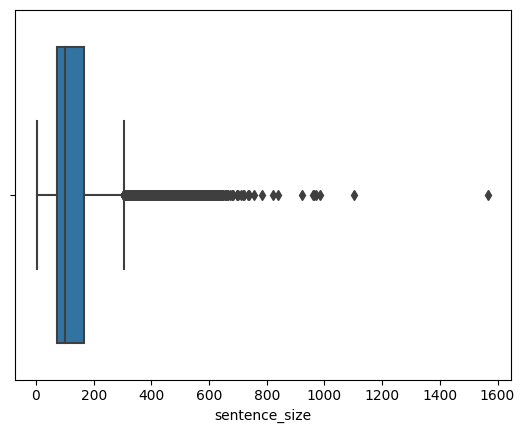

In [14]:
import seaborn as sns

sns.boxplot(x=df['sentence_size'])
df.sentence_size.describe()

count    25000.00000
mean       133.55696
std         98.90158
min          4.00000
25%         73.00000
50%        101.00000
75%        162.00000
max       1316.00000
Name: sentence_size, dtype: float64

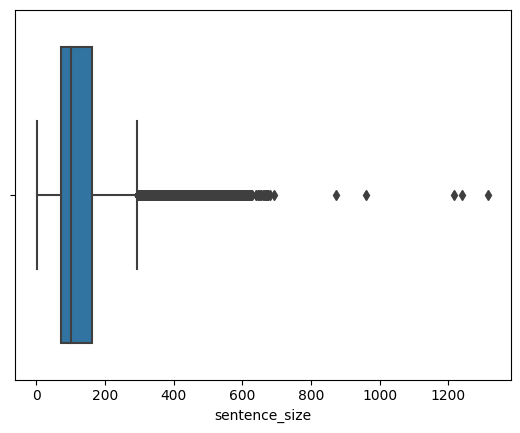

In [15]:
sns.boxplot(x=df_test['sentence_size'])
df_test.sentence_size.describe()

In [16]:

Q1_train = df.sentence_size.quantile(0.25)
Q3_train = df.sentence_size.quantile(0.75)
IQR_train = Q3_train - Q1_train
IQR_train, (Q1_train - 1.5 * IQR_train),(Q3_train + 1.5 * IQR_train), len(df[ df.sentence_size <= (Q3_train + 1.5 * IQR_train)]), len(df[ df.sentence_size > (Q3_train + 1.5 * IQR_train)])


(92.0, -64.0, 304.0, 23183, 1817)

In [17]:
Q1_test = df_test.sentence_size.quantile(0.25)
Q3_test = df_test.sentence_size.quantile(0.75)
IQR_test = Q3_test - Q1_test
IQR_test, (Q1_test - 1.5 * IQR_test),(Q3_test + 1.5 * IQR_test), len(df_test[ df_test.sentence_size <= (Q3_test + 1.5 * IQR_test)]), len(df_test[ df_test.sentence_size > (Q3_test + 1.5 * IQR_test)])


(89.0, -60.5, 295.5, 23151, 1849)

In [18]:
IQR_total = np.minimum((Q3_train + 1.5 * IQR_train),(Q3_test + 1.5 * IQR_test))
sequence_size = int(IQR_total)
sequence_size

295

In [19]:
if ETL_SENTENCE_SIZE == True :
    
    df = check_sentece_size(df,sequence_size)
    df_filtered=df.copy()
    df_filtered = df[df['sentence_size'] > 0] 
    df_filtered = df_filtered.reset_index().drop(["index"], axis = 1)
    
    df_test = check_sentece_size(df_test,sequence_size)
    df_test_filtered=df_test.copy()
    df_test_filtered = df_test[df_test['sentence_size'] > 0] 
    df_test_filtered = df_test_filtered.reset_index().drop(["index"], axis = 1)
    
    
    tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer.fit_on_texts(df_filtered.review.values.tolist())
    tokenizer.fit_on_texts(df_test_filtered.review.values.tolist())
    word_frequency= check_word_frequency(tokenizer)
    
    with open('checkpoints/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open('checkpoints/tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
        
    df.to_pickle("./checkpoints/df.pkl")  
    df_test.to_pickle("./checkpoints/df_test.pkl")  
    
    df_filtered.to_pickle("./checkpoints/df_filtered.pkl")  
    df_test_filtered.to_pickle("./checkpoints/df_test_filtered.pkl") 
    
else:
    df = pd.read_pickle("./checkpoints/df.pkl")
    df_test = pd.read_pickle("./checkpoints/df_test.pkl")
    
    df_filtered = pd.read_pickle("./checkpoints/df_filtered.pkl")
    df_test_filtered = pd.read_pickle("./checkpoints/df_test_filtered.pkl")
    
    with open('checkpoints/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open('checkpoints/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
        


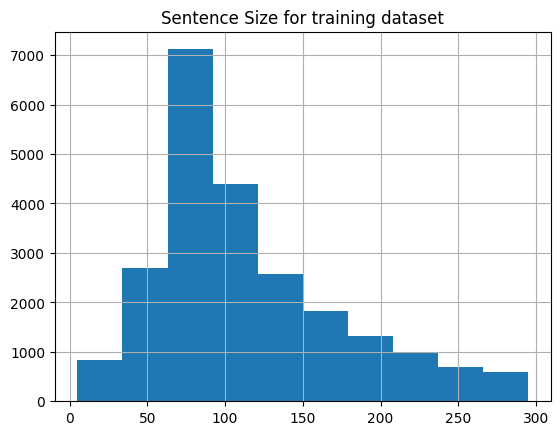

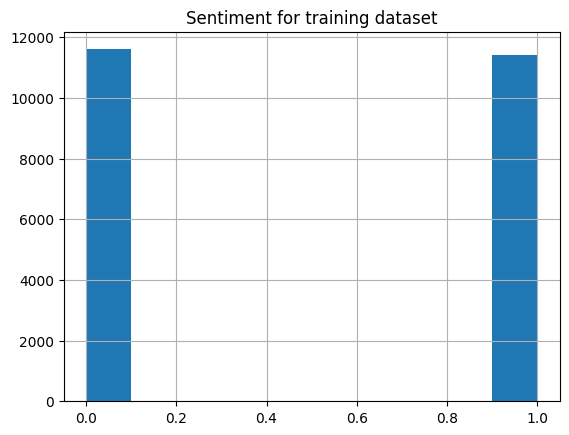

count    23022.000000
mean       113.542872
std         60.148545
min          5.000000
25%         72.000000
50%         96.000000
75%        145.000000
max        295.000000
Name: sentence_size, dtype: float64


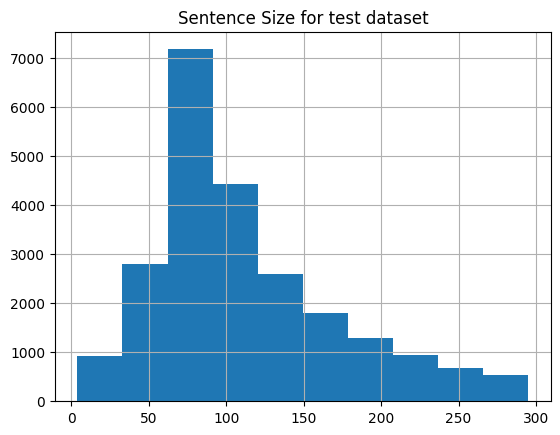

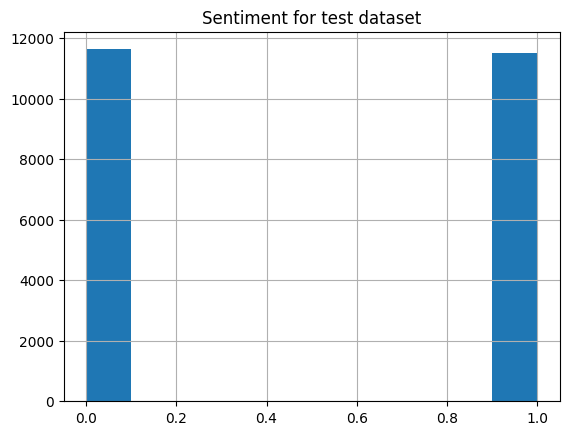

count    23151.000000
mean       111.983327
std         59.382706
min          4.000000
25%         71.000000
50%         95.000000
75%        142.000000
max        295.000000
Name: sentence_size, dtype: float64


In [20]:

plt.figure()
pd.Series(df_filtered.sentence_size).hist()
plt.title("Sentence Size for training dataset")

plt.figure()
pd.Series(df_filtered.sentiment).hist()
plt.title("Sentiment for training dataset")

plt.show()
print(pd.Series(df_filtered.sentence_size).describe())

plt.figure()
pd.Series(df_test_filtered.sentence_size).hist()
plt.title("Sentence Size for test dataset")

plt.figure()
pd.Series(df_test_filtered.sentiment).hist()
plt.title("Sentiment for test dataset")

plt.show()
print(pd.Series(df_test_filtered.sentence_size).describe())

In [21]:
df_filtered_naive = df_filtered.copy()
df_test_filtered_naive = df_test_filtered.copy()

df_filtered_naive.review = df_filtered.review.apply(lambda x : x.replace('.', ''))
df_test_filtered_naive.review = df_test_filtered.review.apply(lambda x : x.replace('.', ''))
df_filtered_naive

,review,sentiment,id,sentence_size
0,story man unnatural feeling pig start opening...,0,0,71.0
1,bromwell high cartoon comedy run time program...,1,1,85.0
2,homelessness george carlin state issue year ne...,1,3,220.0
3,brilliant act lesley ann warren best dramatic...,1,4,97.0
4,film lack something could put finger first cha...,0,5,71.0
...,...,...,...,...
23017,saw ' last night stockholm film festival one h...,0,24995,176.0
23018,film pick pound turn rather good 23rd century ...,0,24996,121.0
23019,christmas together actually come time raise jo...,1,24997,92.0
23020,one dumb film ever see rip nearly ever type t...,0,24998,76.0


In [22]:
word_sentiment_df = pd.DataFrame.from_dict(word_frequency, orient='index').reset_index()
word_sentiment_df.columns = ["words","frequency"]
df_filtered_naive["review_list"] = df_filtered_naive.review.apply(lambda x : tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([x]))[0].split())
df_test_filtered_naive["review_list"] = df_test_filtered_naive.review.apply(lambda x : tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([x]))[0].split())
word_sentiment_df

,words,frequency
0,story,20479
1,man,8777
2,unnatural,73
3,feeling,1829
4,pig,176
...,...,...
41937,mcphail,2
41938,geilgud,1
41939,discouragement,1
41940,brookline,2


In [23]:
import itertools
if TRAIN_WORD_SENTIMENT == True :   
    words_df = pd.DataFrame(columns = ["sent", "words"])

    sent_list = []
    words_list = []
    for i, (s, l) in  enumerate(zip(df_filtered_naive.sentiment, df_filtered_naive.review_list)):

        s = [s]*len(l)
        sent_list.append(s)
        words_list.append(l)
        
        if i %5000 == 0:
            print(i)

    
    for i, (s, l) in  enumerate(zip(df_test_filtered_naive.sentiment, df_test_filtered_naive.review_list)):
        s = [s]*len(l)
        sent_list.append(s)
        words_list.append(l)

        if i %5000 == 0:
            print(i)

    sent_list = list(itertools.chain(*sent_list))
    words_list = list(itertools.chain(*words_list))

    words_df = pd.DataFrame(columns = ["sent", "words"])
    words_df["sent"] = sent_list
    words_df["words"] =words_list

    tmp =words_df[words_df.sent < threshold].groupby(["words"]).agg({"words":"count"}).rename(columns={"words":"negative_frequence"}).reset_index()
    word_sentiment_df = pd.merge(word_sentiment_df,tmp, how="left", on ="words" )

    tmp =words_df[words_df.sent >= threshold].groupby(["words"]).agg({"words":"count"}).rename(columns={"words":"positive_frequence"}).reset_index()
    word_sentiment_df = pd.merge(word_sentiment_df,tmp, how="left", on ="words" )
    word_sentiment_df = word_sentiment_df.fillna(0)

    total_pos_words_freq = np.sum(word_sentiment_df.positive_frequence)
    total_neg_words_freq = np.sum(word_sentiment_df.negative_frequence)
    word_sentiment_df["prob_pos"] = word_sentiment_df.positive_frequence/total_pos_words_freq
    word_sentiment_df["prob_neg"] = word_sentiment_df.negative_frequence/total_neg_words_freq
    

    #Calculate smoothing 
    word_sentiment_df["word_pos_smoothing"] = (word_sentiment_df.positive_frequence + 1)/(total_pos_words_freq + len(word_sentiment_df[word_sentiment_df.positive_frequence >0]))
    word_sentiment_df["word_neg_smoothing"] = (word_sentiment_df.negative_frequence + 1)/(total_neg_words_freq + len(word_sentiment_df[word_sentiment_df.negative_frequence >0]))
    word_sentiment_df["ratio"] = word_sentiment_df["word_pos_smoothing"]/word_sentiment_df["word_neg_smoothing"]

    #Fixing numeric underflow
    word_sentiment_df["loglikelihood"] = word_sentiment_df.ratio.apply(lambda x : np.log(x))

    total_positive_sent = len(df_filtered_naive[df_filtered_naive.sentiment >= threshold]) + len(df_test_filtered_naive[df_test_filtered_naive.sentiment >= threshold])
    total_negative_sent = len(df_filtered_naive[df_filtered_naive.sentiment < threshold]) + len(df_test_filtered_naive[df_test_filtered_naive.sentiment < threshold])

    word_sentiment_df["prior"] = total_positive_sent/total_negative_sent
    word_sentiment_df["logprior"] = np.log(word_sentiment_df["prior"]) 
    
    word_sentiment_df["word_pos_log"] = word_sentiment_df.positive_frequence.apply(lambda x : np.log(x + 1))
    word_sentiment_df["word_neg_log"] = word_sentiment_df.negative_frequence.apply(lambda x : np.log(x + 1 ))

    word_sentiment_df.to_pickle("./checkpoints/word_sentiment_df.pkl")  
else:
    word_sentiment_df = pd.read_pickle("./checkpoints/word_sentiment_df.pkl")

# Naive sentiment analysis model

In [24]:
df_filtered_naive = df_filtered_naive.reset_index().drop(["index"], axis = 1)
df_test_filtered_naive = df_test_filtered_naive.reset_index().drop(["index"], axis = 1)
word_sentiment_df = word_sentiment_df.fillna(0) #word_sentiment_df.fillna(-1)
word_sentiment_df

,words,frequency,negative_frequence,positive_frequence,prob_pos,prob_neg,word_pos_smoothing,word_neg_smoothing,ratio,loglikelihood,prior,logprior,word_pos_log,word_neg_log
0,story,20479,9068.0,11411.0,5.065587e-03,3.937121e-03,4.983417e-03,3.876493e-03,1.285548,0.251185,0.986961,-0.013125,9.342421,9.112617
1,man,8777,3927.0,4850.0,2.153019e-03,1.705015e-03,2.118345e-03,1.679001e-03,1.261670,0.232436,0.986961,-0.013125,8.486940,8.275886
2,unnatural,73,60.0,13.0,5.770978e-06,2.605064e-05,6.113550e-06,2.607410e-05,0.234468,-1.450435,0.986961,-0.013125,2.639057,4.110874
3,feeling,1829,733.0,1096.0,4.865379e-04,3.182520e-04,4.790403e-04,3.137441e-04,1.526850,0.423207,0.986961,-0.013125,7.000334,6.598509
4,pig,176,95.0,81.0,3.595763e-05,4.124685e-05,3.580794e-05,4.103465e-05,0.872627,-0.136247,0.986961,-0.013125,4.406719,4.564348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41937,mcphail,2,0.0,2.0,8.878428e-07,0.000000e+00,1.310047e-06,4.274443e-07,3.064836,1.119994,0.986961,-0.013125,1.098612,0.000000
41938,geilgud,1,1.0,0.0,0.000000e+00,4.341774e-07,4.366822e-07,8.548886e-07,0.510806,-0.671766,0.986961,-0.013125,0.000000,0.693147
41939,discouragement,1,0.0,1.0,4.439214e-07,0.000000e+00,8.733644e-07,4.274443e-07,2.043224,0.714529,0.986961,-0.013125,0.693147,0.000000
41940,brookline,2,0.0,2.0,8.878428e-07,0.000000e+00,1.310047e-06,4.274443e-07,3.064836,1.119994,0.986961,-0.013125,1.098612,0.000000


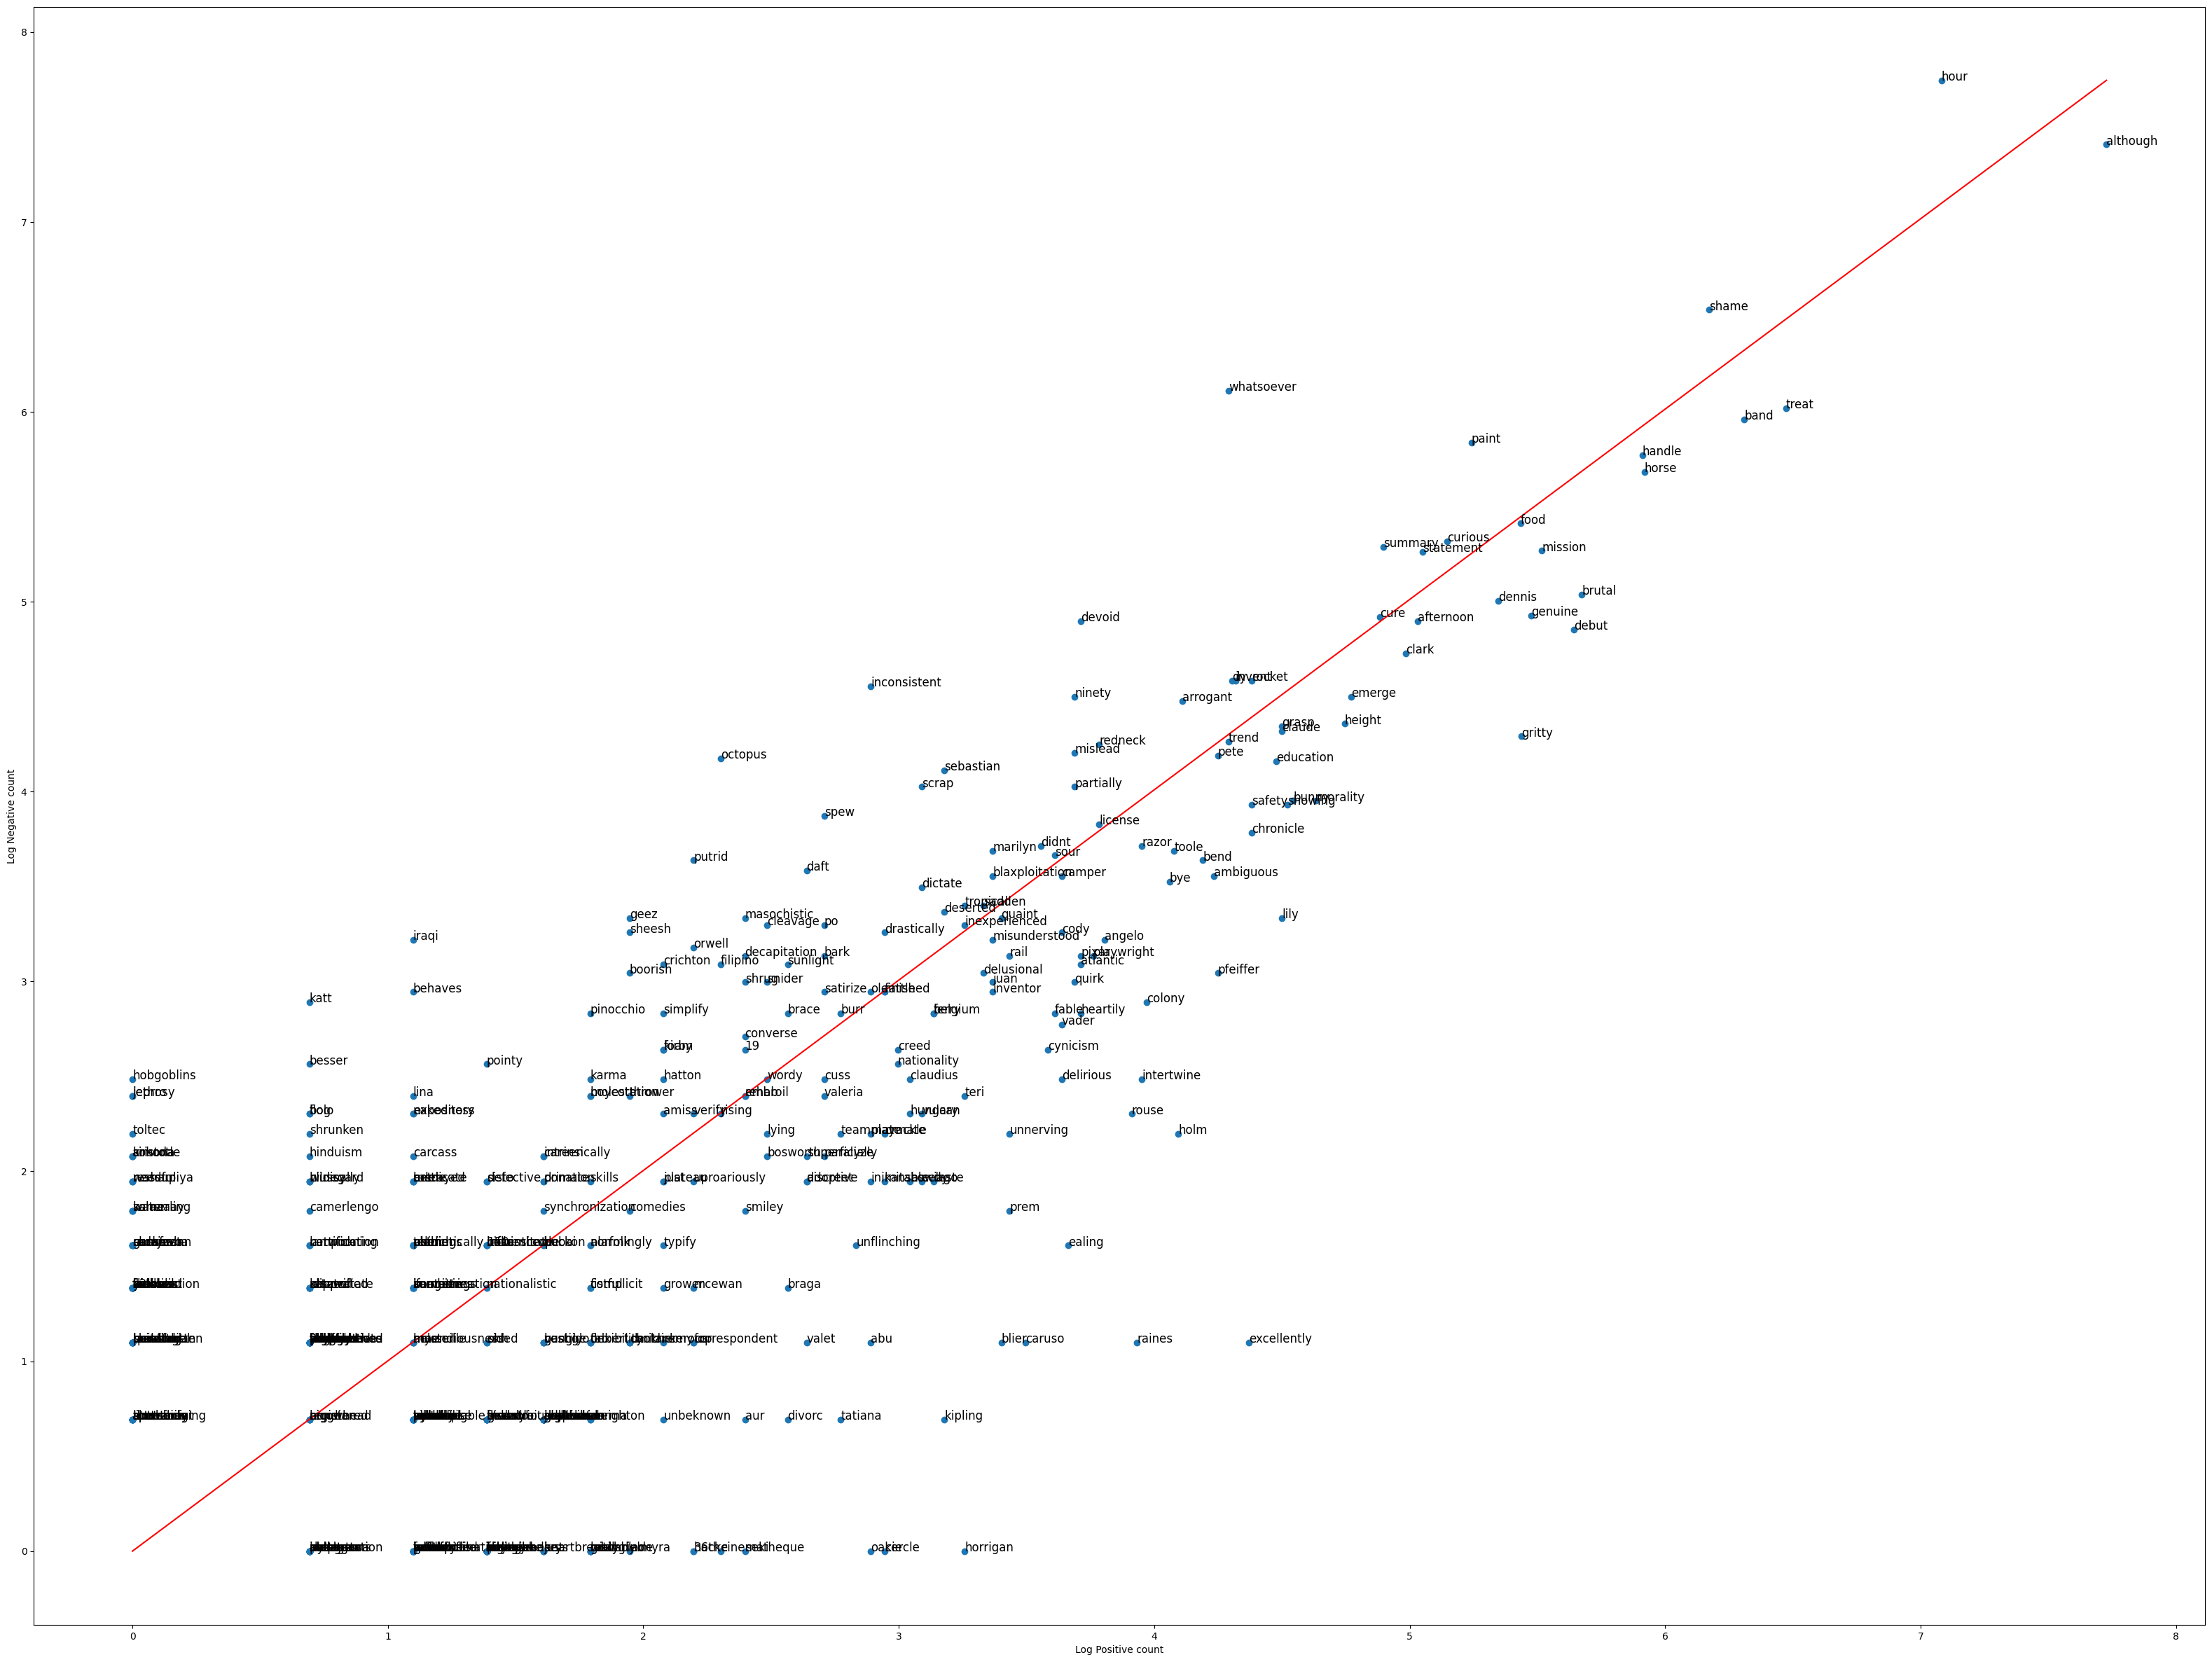

In [25]:
d = word_sentiment_df.sample(frac=0.01)    
plot_words(d)

In [26]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
tokenizer.fit_on_texts(df_filtered_naive.review.values.tolist())
tokenizer.fit_on_texts(df_test_filtered_naive.review.values.tolist())
word_frequency= check_word_frequency(tokenizer)

In [27]:
def naive_bayes_predict(test_sent, word_sentiment_df):
    # initialize probability to zero
    p = 0

    # add the logprior
    p += word_sentiment_df["logprior"].values[0]
    p += word_sentiment_df[word_sentiment_df.words.isin(test_sent)].loglikelihood.sum()
   
    return p

test_df_naive= df_test_filtered_naive.sample(frac=0.05)    
test_df_naive["sent_filtered"] = test_df_naive.sentiment.apply(lambda x: 1 if x>=threshold else 0 )

test_df_naive["prediction"] = test_df_naive.review_list.apply(lambda x : 1 if naive_bayes_predict(x,word_sentiment_df) >0 else 0)


test_df_naive

,review,sentiment,id,sentence_size,review_list,sent_filtered,prediction
3821,please watch <3 STARS> series go see movie tra...,0,4130,73.0,"[please, watch, <3, stars>, series, go, see, m...",0,0
2307,well sci fi channel keep churn turkey seem ge...,0,2494,80.0,"[well, sci, fi, channel, keep, churn, turkey, ...",0,0
22370,release king boxer u k film essentially firs...,1,24140,215.0,"[release, king, boxer, u, k, film, essentially...",1,1
18182,movie maker know hard tell story draw people s...,1,19620,55.0,"[movie, maker, know, hard, tell, story, draw, ...",1,1
8306,time movie feature dwarf midget prominent role...,0,8949,265.0,"[time, movie, feature, dwarf, midget, prominen...",0,0
...,...,...,...,...,...,...,...
6331,series continue frustrate annoy go drag anoth...,0,6816,78.0,"[series, continue, frustrate, annoy, go, drag,...",0,0
6387,concept movie quite good somehow execution fa...,0,6872,169.0,"[concept, movie, quite, good, somehow, executi...",0,0
22305,shame important film like virtually unknown t...,1,24071,180.0,"[shame, important, film, like, virtually, unkn...",1,1
19089,extramarital see b actress traci lord best wr...,1,20599,89.0,"[extramarital, see, b, actress, traci, lord, b...",1,1


In [28]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_df_naive.prediction.tolist(), test_df_naive.sent_filtered)
m.result().numpy()

0.9015544

In [29]:
test_elements_index = np.random.choice(1000, 200, replace=False) 
print("devtest_elements_index length : ",(test_elements_index))

test_df_naive_filtered = df_test_filtered_naive[df_test_filtered_naive.index.isin(test_elements_index)] 
df_test_noprocess_filtered = df_test_noprocess.copy()

test_df_naive_filtered["review_list"] = test_df_naive_filtered.review.apply(lambda x : x.split())
test_df_naive_filtered["sent_filtered"] = test_df_naive_filtered.sentiment.apply(lambda x: 1 if x>=threshold else 0 )
test_df_naive_filtered = test_df_naive_filtered.reset_index().drop(["index"], axis = 1)
test_df_naive_filtered

devtest_elements_index length :  [959 113 457 222 142 756 802 994 595   2 956 857 698 498 131 216 450 250
 609 431 261  81 672 785 735 270 303 719 729 433 233 408 697 382  69 610
  96 811 973 574 748 396 773 514 793 358 936 737 807 473 493 800 167 203
 849 600 578 133 412  44  16 307 982 370 306 379 354 739 313 247 866 704
 437 884 168 878 421 340 538 553 164 312 806 699 860 269 413 525 248 641
 429 419 198 148 315 876 796 776 224 971 470 229 102 856 481 799 633 176
 362  43 583 278 728 591 213 201 613  12 596 592 236 506 892 309 238 720
 722 586 504 637 344 546 220 258 432 230 327 932 661 679 948 841 844 848
  79 706 951 804 847 363 193 718 605 101 310 537 626  30 675 934 601 663
 486 941 985  65 655 274  78 343 872 975 321 463 990 547 456 430 676  23
  17  77 375 668 963 444 758 693 337   6 282 308 818 636 913 376 809 943
 187 901]


C:\Users\yanie\AppData\Local\Temp\ipykernel_14760\83755141.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_naive_filtered["review_list"] = test_df_naive_filtered.review.apply(lambda x : x.split())
C:\Users\yanie\AppData\Local\Temp\ipykernel_14760\83755141.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_naive_filtered["sent_filtered"] = test_df_naive_filtered.sentiment.apply(lambda x: 1 if x>=threshold else 0 )


,review,sentiment,id,sentence_size,review_list,sent_filtered
0,example majority action film generic bore rea...,0,2,139.0,"[example, majority, action, film, generic, bor...",0
1,even beatles could write song everyone like al...,0,6,178.0,"[even, beatles, could, write, song, everyone, ...",0
2,german horror film one weird see aware connec...,0,12,86.0,"[german, horror, film, one, weird, see, aware,...",0
3,movie amazing fact real people portray real li...,1,16,89.0,"[movie, amazing, fact, real, people, portray, ...",1
4,'' tokyo eye `` tell year old japanese girl fa...,0,17,79.0,"['', tokyo, eye, ``, tell, year, old, japanese...",0
...,...,...,...,...,...,...
195,john knowles modern masterpiece separate peace...,0,1057,181.0,"[john, knowles, modern, masterpiece, separate,...",0
196,magazine columnist write life farm house fact ...,1,1065,72.0,"[magazine, columnist, write, life, farm, house...",1
197,rivalry brother lead main story line navy com...,0,1068,118.0,"[rivalry, brother, lead, main, story, line, na...",0
198,stephane audran eponymous heroine beautifully ...,1,1073,88.0,"[stephane, audran, eponymous, heroine, beautif...",1


In [30]:
df_test_noprocess_filtered["sent_filtered"] = df_test_noprocess_filtered.sentiment.apply(lambda x: 1 if x>=threshold else 0 )
df_test_noprocess_filtered

,review,sentiment,id,sent_filtered
0,i went and saw this movie last night after bei...,1,0,1
1,once again mr. costner has dragged out a movie...,0,1,0
2,this is an example of why the majority of acti...,0,2,0
3,actor turned director bill paxton follows up h...,1,3,1
4,"first of all i hate those moronic rappers, who...",0,4,0
...,...,...,...,...
24995,"from the start of ""the edge of love"", the view...",1,24995,1
24996,"this movie, with all its complexity and subtle...",1,24996,1
24997,four things intrigued me as to this film - fir...,0,24997,0
24998,david bryce's comments nearby are exceptionall...,0,24998,0


In [31]:
print('Truth Predicted Tweet')
index = 0
for i in range(len(test_df_naive_filtered)):
    
    y_hat = naive_bayes_predict(test_df_naive_filtered.review_list.values[i], word_sentiment_df)
    
    y = df_test_noprocess_filtered.sent_filtered.values[i]
    x  = df_test_noprocess_filtered[(df_test_noprocess_filtered.id == test_df_naive_filtered.id.values[i])].review.tolist()
    
    if y != (np.sign(y_hat) > 0) and index <=10:

        aux = test_df_naive_filtered.review.values[i]
        print(f'ID : {test_df_naive_filtered.id.values[i]}  Y : {y}\ny_hat:{int(np.sign(y_hat)> 0 )} :  \nReal : {x} \n\nProcessed : {aux} \n ------------------------\n')
        index += 1

Truth Predicted Tweet
ID : 2  Y : 1
y_hat:0 :  
Real : ["this is an example of why the majority of action films are the same. generic and boring, there's really nothing worth watching here. a complete waste of the then barely-tapped talents of ice-t and ice cube, who've each proven many times over that they are capable of acting, and acting well. don't bother with this one, go see new jack city, ricochet or watch new york undercover for ice-t, or boyz n the hood, higher learning or friday for ice cube and see the real deal. ice-t's horribly cliched dialogue alone makes this film grate at the teeth, and i'm still wondering what the heck bill paxton was doing in this film? and why the heck does he always play the exact same character? from aliens onward, every film i've seen with bill paxton has him playing the exact same irritating character, and at least in aliens his character died, which made it somewhat gratifying...<br /><br />overall, this is second-rate action trash. there are co

In [32]:
y_out=[]
for i in range(len(df_test_filtered_naive)):
    y_hat = naive_bayes_predict(df_test_filtered_naive.review.values[i].split(), word_sentiment_df)
    y_out.append(int(np.sign(y_hat) > 0))


In [33]:
yhat = np.array(y_out).reshape((len(y_out),1))

y_test = df_test_filtered_naive.sentiment.values
y_test = y_test.reshape((len(y_test),1))

pr = tf.keras.metrics.AUC(curve="PR")

p = tf.keras.metrics.Precision()
p.update_state(y_test,yhat)

r = tf.keras.metrics.Recall()
r.update_state(y_test,yhat)

print("AUC",pr(y_test, yhat).numpy()," | Precision : ",p.result().numpy(), " | Recall : ",r.result().numpy())
confusion_matrix(list(y_test),list(yhat))

AUC 0.88479537  | Precision :  0.9148611  | Recall :  0.8838704


array([[10691,   947],
       [ 1337, 10176]], dtype=int64)

In [34]:
test_df_naive_filtered

,review,sentiment,id,sentence_size,review_list,sent_filtered
0,example majority action film generic bore rea...,0,2,139.0,"[example, majority, action, film, generic, bor...",0
1,even beatles could write song everyone like al...,0,6,178.0,"[even, beatles, could, write, song, everyone, ...",0
2,german horror film one weird see aware connec...,0,12,86.0,"[german, horror, film, one, weird, see, aware,...",0
3,movie amazing fact real people portray real li...,1,16,89.0,"[movie, amazing, fact, real, people, portray, ...",1
4,'' tokyo eye `` tell year old japanese girl fa...,0,17,79.0,"['', tokyo, eye, ``, tell, year, old, japanese...",0
...,...,...,...,...,...,...
195,john knowles modern masterpiece separate peace...,0,1057,181.0,"[john, knowles, modern, masterpiece, separate,...",0
196,magazine columnist write life farm house fact ...,1,1065,72.0,"[magazine, columnist, write, life, farm, house...",1
197,rivalry brother lead main story line navy com...,0,1068,118.0,"[rivalry, brother, lead, main, story, line, na...",0
198,stephane audran eponymous heroine beautifully ...,1,1073,88.0,"[stephane, audran, eponymous, heroine, beautif...",1
